In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
import torch
torch.cuda.device_count()

1

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob
# import wandb

import monai
from monai.losses import DiceCELoss, DiceFocalLoss, FocalLoss
from monai.inferers import sliding_window_inference
from monai import transforms

from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    MapTransform,
    ScaleIntensityd,
    #AddChanneld,
    SpatialPadd,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    ConcatItemsd,
    AdjustContrastd, 
    Rand3DElasticd,
    HistogramNormalized,
    NormalizeIntensityd,
    Invertd,
    SaveImage,

)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, UNETR, SegResNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from monai import data


from monai.utils import first, set_determinism
from sklearn.model_selection import train_test_split
import json


import torch

In [3]:
set_determinism(seed=1024)

In [4]:
import os
import json
import random
from glob import glob

def generate_paths(patient_id):
    base_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/data'
    return {
        'id': os.path.join(base_dir, patient_id),
        'ct': os.path.join(base_dir, patient_id, f"{patient_id}_ct.nii.gz"),
        'seg': os.path.join(base_dir, patient_id, f"{patient_id}_gt.nii.gz")
    }

# Assign each data entry to a random fold
all_data = []
num_folds = 5
centers = ['CHUM', 'CHUP', 'CHUS', 'CHUV']  # Centers to include

for file_dir in sorted(glob('data/*')):
    patient_id = file_dir.split('/')[-1]
    # Check if the file belongs to one of the specified centers
    if any(patient_id.startswith(center) for center in centers):
        entry = generate_paths(patient_id)
        entry['fold'] = random.randint(1, num_folds) - 1
        all_data.append(entry)

# Compile data into a JSON structure
data_json = {"training": all_data}

# Save to JSON file
json_file_path = "/home/nada.saadi/MIS-FM/hecktor2022_cropped/4centers-ct-only.json"
with open(json_file_path, 'w') as f:
    json.dump(data_json, f, indent=4)

print(f"JSON file created at {json_file_path}")


JSON file created at /home/nada.saadi/MIS-FM/hecktor2022_cropped/4centers-ct-only.json


In [5]:
data_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped'
json_dir = '/home/nada.saadi/MIS-FM/hecktor2022_cropped/4centers-ct-only.json'

In [6]:
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

In [7]:
train_files, validation_files = datafold_read(datalist=json_dir, basedir=data_dir, fold=0)
len(train_files), len(validation_files)

(204, 49)

/home/nada.saadi/miniconda3/envs/clam/lib/python3.8/site-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (200, 295), channels = 200,please make sure the input is in the channel-first format.
  warnings.warn(


torch.Size([200, 200, 295])


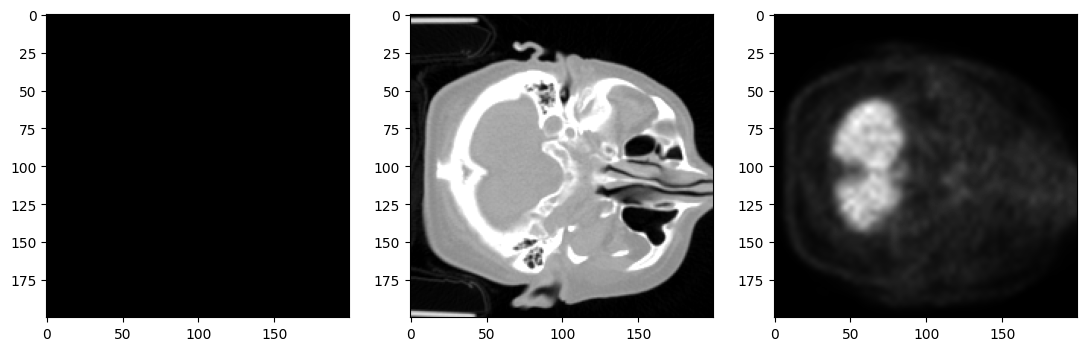

In [7]:
# from skimage import measure

# slice_num = 133
# gt = monai.transforms.LoadImage(ensure_channel_first=True)('data/CHUM-001/CHUM-001_gt.nii.gz')
# plt.figure("image", (18, 10))
# gt = monai.transforms.Orientation(axcodes='RAS')(gt[0])
# plt.subplot(2, 4, 1)
# plt.imshow(gt[:,:,slice_num], cmap='gray')
# print(gt.shape)

# #contours = measure.find_contours(gt[:,slice_num,:], 0.5)[0]
# #plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

# ct = monai.transforms.LoadImage(ensure_channel_first=True)('data/CHUM-001/CHUM-001_ct.nii.gz')
# ct = monai.transforms.Orientation(axcodes='RAS')(ct[0])
# ct = torch.clip(ct, min=-1000, max=600)
# plt.subplot(2, 4, 2)
# plt.imshow(ct[:,:,slice_num], cmap='gray')
# #plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

# pt = monai.transforms.LoadImage(ensure_channel_first=True)('data/CHUM-001/CHUM-001_pt.nii.gz')
# pt = monai.transforms.Orientation(axcodes='RAS')(pt[0])
# plt.subplot(2, 4, 3)
# plt.imshow(pt[:,:,slice_num], cmap='gray')
# #plt.plot(contours[:, 1], contours[:, 0], linewidth=0.8, c='red',  alpha = 0.8)

In [8]:
class ClipCT(MapTransform):
    """
    Convert labels to multi channels based on hecktor classes:
    label 1 is the tumor
    label 2 is the lymph node

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if key == "ct":
                d[key] = torch.clip(d[key], min=-200, max=200)
            # elif key == "pt":
            #     d[key] = torch.clip(d[key], d[key].min(), 5)
        return d

class MulPTFM(MapTransform):
    """
    Mult PT and FM 

    """

    def __call__(self, data):
        d = dict(data)

        fm = d["ct"] > 0
        d["pt"] = d["pt"] * fm
        return d

class SelectClass(MapTransform):
    """
    Select the class for which you want to fine tune the model 

    """
    # def __init__(self, keys, cls=1):
    #     super(self).__init__(keys)
    #     self.cls = cls

    def __call__(self, data):
        d = dict(data)
        d["seg"][d["seg"] == 1] = 0
        # d["seg"][d["seg"] == 2] = 1
        
        return d

In [9]:
num_samples = 4

train_transforms = Compose(
    [
        LoadImaged(keys=["ct", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct",  "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct",  "seg"], axcodes="PLS"),
        #NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        #ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
        #NormalizeIntensityd(keys=["ctpt"], channel_wise=True),
        RandCropByPosNegLabeld(
            keys=["ct", "seg"],
            label_key="seg",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="ct",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[0],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[1],
            prob=0.20,
        ),
        RandFlipd(
            keys=["ct", "seg"],
            spatial_axis=[2],
            prob=0.20,
        ),
        RandRotate90d(
            keys=["ct", "seg"],
            prob=0.20,
            max_k=3,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["ct", "seg"], ensure_channel_first = True),
        SpatialPadd(keys=["ct", "seg"], spatial_size=(200, 200, 310), method='end'),
        Orientationd(keys=["ct",  "seg"], axcodes="PLS"),
        #NormalizeIntensityd(keys=["pt"]),
        ClipCT(keys=["ct"]),
        ScaleIntensityd(keys=["ct"], minv=0, maxv=1),
        #MulPTFM(keys=["ct","pt"]),
        #ConcatItemsd(keys=["pt", "ct"], name="ctpt"),
    ]
)

In [10]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=8,
    pin_memory=torch.cuda.is_available(),
    )

val_ds = monai.data.Dataset(data=validation_files, transform=val_transforms)

val_loader = DataLoader(
    val_ds, 
    batch_size=2, 
    num_workers=8, 
    shuffle= False)

In [11]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = SegResNet(in_channels=2, 
#                   out_channels=3, 
#                   init_filters=16).to(device)
      
model = UNETR(
    in_channels=1,
    out_channels=3,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072, 
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

/home/nada.saadi/miniconda3/envs/clam/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


In [12]:
torch.backends.cudnn.benchmark = True
def poly_lr(epoch, max_epochs, initial_lr, exponent=0.9):
    return initial_lr * (1 - epoch / max_epochs)**exponent

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [13]:
model_dir = '/home/nada.saadi/CTPET/hecktor2022_cropped/4centers-ctonly'

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["ct"].cuda(), batch["seg"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice_metric_batch(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps)" % (global_step, 10.0)
            )
        mean_dice_val = dice_metric.aggregate().item()
        metric_batch_val = dice_metric_batch.aggregate()

        metric_tumor = metric_batch_val[0].item()
        metric_lymph = metric_batch_val[1].item()

        dice_metric.reset()
        dice_metric_batch.reset()
    return mean_dice_val, metric_tumor, metric_lymph


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["ct"].cuda(), batch["seg"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)"
            % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val, metric_tumor, metric_lymph = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            metric_values_tumor.append(metric_tumor)
            metric_values_lymph.append(metric_lymph)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(model_dir, "4centers-ctonly.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val, metric_tumor, metric_lymph
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {} Current Avg. tumor Dice: {} Current Avg. lymph Dice: {}".format(
                        dice_val_best, dice_val,  metric_tumor, metric_lymph
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 18000
eval_num = 100

post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")

epoch = 0
max_num_epochs = 530

global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
metric_values_tumor = []
metric_values_lymph = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
    # wandb.log({'learning_rate': optimizer.param_groups[0]['lr']})
    # wandb.log({'Best Dice': dice_val_best})
    epoch += 1
    #optimizer.param_groups[0]['lr'] = poly_lr(epoch, max_num_epochs, 0.005676 , 0.9)
# model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_luck_UNETr_prompt.pth")))

Training (X / X Steps) (loss=X.X):   0%|          | 0/102 [00:00<?, ?it/s]

Training (100 / 18000 Steps) (loss=1.19255):  99%|█████████▉| 101/102 [01:26<00:10, 10.24s/it]

Model Was Saved ! Current Best Avg. Dice: 0.00021905532048549503 Current Avg. Dice: 0.00021905532048549503 Current Avg. tumor Dice: 0.00043811064097099006 Current Avg. lymph Dice: 0.0


Training (200 / 18000 Steps) (loss=1.13573):  97%|█████████▋| 99/102 [01:15<00:28,  9.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.00021905532048549503 Current Avg. Dice: 1.8608785467222333e-05 Current Avg. tumor Dice: 3.7217570934444666e-05 Current Avg. lymph Dice: 0.0


Training (300 / 18000 Steps) (loss=1.03109):  95%|█████████▌| 97/102 [01:13<00:47,  9.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.00021905532048549503 Current Avg. Dice: 7.544886670984852e-07 Current Avg. tumor Dice: 1.5089773341969703e-06 Current Avg. lymph Dice: 0.0


Training (400 / 18000 Steps) (loss=0.99008):  93%|█████████▎| 95/102 [01:13<01:06,  9.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.00021905532048549503 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (500 / 18000 Steps) (loss=0.94338):  91%|█████████ | 93/102 [01:13<01:26,  9.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.00021905532048549503 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (600 / 18000 Steps) (loss=0.92081):  89%|████████▉ | 91/102 [01:12<01:45,  9.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.00021905532048549503 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (700 / 18000 Steps) (loss=0.87815):  87%|████████▋ | 89/102 [01:12<02:06,  9.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.00021905532048549503 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (800 / 18000 Steps) (loss=0.86104):  85%|████████▌ | 87/102 [01:11<02:24,  9.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.00021905532048549503 Current Avg. Dice: 0.0 Current Avg. tumor Dice: 0.0 Current Avg. lymph Dice: 0.0


Training (900 / 18000 Steps) (loss=0.84342):  83%|████████▎ | 85/102 [01:10<02:44,  9.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.00021905532048549503 Current Avg. Dice: 1.0721075341280084e-05 Current Avg. tumor Dice: 2.1442150682560168e-05 Current Avg. lymph Dice: 0.0


Training (1000 / 18000 Steps) (loss=0.82106):  81%|████████▏ | 83/102 [01:10<03:07,  9.89s/it]

Model Was Saved ! Current Best Avg. Dice: 0.00048068398609757423 Current Avg. Dice: 0.00048068398609757423 Current Avg. tumor Dice: 0.0009613678557798266 Current Avg. lymph Dice: 0.0


Training (1100 / 18000 Steps) (loss=0.81938):  79%|███████▉  | 81/102 [01:09<03:31, 10.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.008482693694531918 Current Avg. Dice: 0.008482693694531918 Current Avg. tumor Dice: 0.01607629284262657 Current Avg. lymph Dice: 0.0


Training (1200 / 18000 Steps) (loss=0.79358):  77%|███████▋  | 79/102 [01:08<03:49,  9.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.03760863468050957 Current Avg. Dice: 0.03760863468050957 Current Avg. tumor Dice: 0.06879743933677673 Current Avg. lymph Dice: 0.0


Training (1300 / 18000 Steps) (loss=0.77972):  75%|███████▌  | 77/102 [01:08<04:09, 10.00s/it]

Model Was Saved ! Current Best Avg. Dice: 0.07601451128721237 Current Avg. Dice: 0.07601451128721237 Current Avg. tumor Dice: 0.13860054314136505 Current Avg. lymph Dice: 0.0


Training (1400 / 18000 Steps) (loss=0.80557):  74%|███████▎  | 75/102 [01:06<04:24,  9.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.07601451128721237 Current Avg. Dice: 0.07183298468589783 Current Avg. tumor Dice: 0.1316097378730774 Current Avg. lymph Dice: 0.0


Training (1500 / 18000 Steps) (loss=0.76337):  72%|███████▏  | 73/102 [01:06<04:47,  9.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.08975401520729065 Current Avg. Dice: 0.08975401520729065 Current Avg. tumor Dice: 0.16626589000225067 Current Avg. lymph Dice: 0.0


Training (1600 / 18000 Steps) (loss=0.77697):  70%|██████▉   | 71/102 [01:05<05:10, 10.02s/it]

Model Was Saved ! Current Best Avg. Dice: 0.10900074988603592 Current Avg. Dice: 0.10900074988603592 Current Avg. tumor Dice: 0.14437463879585266 Current Avg. lymph Dice: 0.0695606991648674


Training (1700 / 18000 Steps) (loss=0.74116):  68%|██████▊   | 69/102 [01:03<05:24,  9.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.12250208109617233 Current Avg. Dice: 0.12250208109617233 Current Avg. tumor Dice: 0.14939729869365692 Current Avg. lymph Dice: 0.09586692601442337


Training (1800 / 18000 Steps) (loss=0.73480):  66%|██████▌   | 67/102 [01:03<05:45,  9.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.13473071157932281 Current Avg. Dice: 0.13473071157932281 Current Avg. tumor Dice: 0.18756210803985596 Current Avg. lymph Dice: 0.07492201775312424


Training (1900 / 18000 Steps) (loss=0.69824):  64%|██████▎   | 65/102 [01:02<06:06,  9.91s/it]

Model Was Saved ! Current Best Avg. Dice: 0.173147052526474 Current Avg. Dice: 0.173147052526474 Current Avg. tumor Dice: 0.19034238159656525 Current Avg. lymph Dice: 0.16029803454875946


Training (2000 / 18000 Steps) (loss=0.69999):  62%|██████▏   | 63/102 [01:00<06:17,  9.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.173147052526474 Current Avg. Dice: 0.1442474126815796 Current Avg. tumor Dice: 0.1705075055360794 Current Avg. lymph Dice: 0.11661861091852188


Training (2100 / 18000 Steps) (loss=0.63136):  60%|█████▉    | 61/102 [01:00<06:49,  9.99s/it]

Model Was Saved ! Current Best Avg. Dice: 0.1992335468530655 Current Avg. Dice: 0.1992335468530655 Current Avg. tumor Dice: 0.20067785680294037 Current Avg. lymph Dice: 0.2052236944437027


Training (2200 / 18000 Steps) (loss=0.69312):  58%|█████▊    | 59/102 [00:59<07:05,  9.90s/it]

Model Was Saved ! Current Best Avg. Dice: 0.20812039077281952 Current Avg. Dice: 0.20812039077281952 Current Avg. tumor Dice: 0.18923631310462952 Current Avg. lymph Dice: 0.23394393920898438


Training (2300 / 18000 Steps) (loss=0.62093):  56%|█████▌    | 57/102 [00:58<07:18,  9.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.20812039077281952 Current Avg. Dice: 0.20181460678577423 Current Avg. tumor Dice: 0.20300649106502533 Current Avg. lymph Dice: 0.20553956925868988


Training (2400 / 18000 Steps) (loss=0.69231):  54%|█████▍    | 55/102 [00:58<07:34,  9.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.20812039077281952 Current Avg. Dice: 0.20074208080768585 Current Avg. tumor Dice: 0.19354188442230225 Current Avg. lymph Dice: 0.21128705143928528


Training (2500 / 18000 Steps) (loss=0.65974):  52%|█████▏    | 53/102 [00:56<07:52,  9.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.20812039077281952 Current Avg. Dice: 0.18645897507667542 Current Avg. tumor Dice: 0.2264193892478943 Current Avg. lymph Dice: 0.13903789222240448


Training (2600 / 18000 Steps) (loss=0.70599):  50%|█████     | 51/102 [00:57<08:39, 10.19s/it]

Model Was Saved ! Current Best Avg. Dice: 0.21691137552261353 Current Avg. Dice: 0.21691137552261353 Current Avg. tumor Dice: 0.22361700236797333 Current Avg. lymph Dice: 0.21560318768024445


Training (2700 / 18000 Steps) (loss=0.68506):  48%|████▊     | 49/102 [00:55<08:51, 10.03s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2704083025455475 Current Avg. Dice: 0.2704083025455475 Current Avg. tumor Dice: 0.24114227294921875 Current Avg. lymph Dice: 0.3086754381656647


Training (2800 / 18000 Steps) (loss=0.54683):  46%|████▌     | 47/102 [00:54<08:46,  9.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2704083025455475 Current Avg. Dice: 0.22864115238189697 Current Avg. tumor Dice: 0.20443418622016907 Current Avg. lymph Dice: 0.2593995928764343


Training (2900 / 18000 Steps) (loss=0.67973):  44%|████▍     | 45/102 [00:53<09:21,  9.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2704083025455475 Current Avg. Dice: 0.25961586833000183 Current Avg. tumor Dice: 0.23547565937042236 Current Avg. lymph Dice: 0.2926403880119324


Training (3000 / 18000 Steps) (loss=0.69519):  42%|████▏     | 43/102 [00:52<09:42,  9.87s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2704083025455475 Current Avg. Dice: 0.2402811497449875 Current Avg. tumor Dice: 0.26488393545150757 Current Avg. lymph Dice: 0.21886277198791504


Training (3100 / 18000 Steps) (loss=0.68547):  40%|████      | 41/102 [00:51<09:52,  9.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2704083025455475 Current Avg. Dice: 0.2362566441297531 Current Avg. tumor Dice: 0.2247314304113388 Current Avg. lymph Dice: 0.25398990511894226


Training (3200 / 18000 Steps) (loss=0.67557):  38%|███▊      | 39/102 [00:51<10:28,  9.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2704083025455475 Current Avg. Dice: 0.2513435184955597 Current Avg. tumor Dice: 0.2373838573694229 Current Avg. lymph Dice: 0.2726982831954956


Training (3300 / 18000 Steps) (loss=0.55735):  36%|███▋      | 37/102 [00:49<10:35,  9.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2704083025455475 Current Avg. Dice: 0.2689972221851349 Current Avg. tumor Dice: 0.2651222050189972 Current Avg. lymph Dice: 0.28192663192749023


Training (3400 / 18000 Steps) (loss=0.72165):  34%|███▍      | 35/102 [00:50<11:04,  9.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2704083025455475 Current Avg. Dice: 0.23905512690544128 Current Avg. tumor Dice: 0.2226221114397049 Current Avg. lymph Dice: 0.2689812481403351


Training (3500 / 18000 Steps) (loss=0.69153):  32%|███▏      | 33/102 [00:49<11:33, 10.05s/it]

Model Was Saved ! Current Best Avg. Dice: 0.2792245149612427 Current Avg. Dice: 0.2792245149612427 Current Avg. tumor Dice: 0.2581595480442047 Current Avg. lymph Dice: 0.3072134256362915


Training (3600 / 18000 Steps) (loss=0.64969):  30%|███       | 31/102 [00:47<11:38,  9.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.2792245149612427 Current Avg. Dice: 0.26679062843322754 Current Avg. tumor Dice: 0.2257298231124878 Current Avg. lymph Dice: 0.3186555504798889


Training (3700 / 18000 Steps) (loss=0.64043):  28%|██▊       | 29/102 [00:47<12:07,  9.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.29336830973625183 Current Avg. Dice: 0.29336830973625183 Current Avg. tumor Dice: 0.2816881835460663 Current Avg. lymph Dice: 0.3087938725948334


Training (3800 / 18000 Steps) (loss=0.66119):  26%|██▋       | 27/102 [00:46<12:29,  9.99s/it]

Model Was Saved ! Current Best Avg. Dice: 0.29553914070129395 Current Avg. Dice: 0.29553914070129395 Current Avg. tumor Dice: 0.2541612386703491 Current Avg. lymph Dice: 0.3469080924987793


Training (3900 / 18000 Steps) (loss=0.61980):  25%|██▍       | 25/102 [00:45<12:37,  9.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.29553914070129395 Current Avg. Dice: 0.26910364627838135 Current Avg. tumor Dice: 0.22591640055179596 Current Avg. lymph Dice: 0.32734328508377075


Training (4000 / 18000 Steps) (loss=0.58108):  23%|██▎       | 23/102 [00:43<12:43,  9.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.29553914070129395 Current Avg. Dice: 0.27362972497940063 Current Avg. tumor Dice: 0.2462938129901886 Current Avg. lymph Dice: 0.30572080612182617


Training (4100 / 18000 Steps) (loss=0.64052):  21%|██        | 21/102 [00:42<13:07,  9.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.29553914070129395 Current Avg. Dice: 0.28764668107032776 Current Avg. tumor Dice: 0.26663392782211304 Current Avg. lymph Dice: 0.31797313690185547


Training (4200 / 18000 Steps) (loss=0.58309):  19%|█▊        | 19/102 [00:43<13:50, 10.01s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3148483633995056 Current Avg. Dice: 0.3148483633995056 Current Avg. tumor Dice: 0.31367963552474976 Current Avg. lymph Dice: 0.32168281078338623


Training (4300 / 18000 Steps) (loss=0.65820):  17%|█▋        | 17/102 [00:43<14:28, 10.22s/it]

Model Was Saved ! Current Best Avg. Dice: 0.32354679703712463 Current Avg. Dice: 0.32354679703712463 Current Avg. tumor Dice: 0.32047516107559204 Current Avg. lymph Dice: 0.3351336717605591


Training (4400 / 18000 Steps) (loss=0.62426):  15%|█▍        | 15/102 [00:40<14:17,  9.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32354679703712463 Current Avg. Dice: 0.27895697951316833 Current Avg. tumor Dice: 0.29816803336143494 Current Avg. lymph Dice: 0.2575596570968628


Training (4500 / 18000 Steps) (loss=0.59309):  13%|█▎        | 13/102 [00:40<14:40,  9.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32354679703712463 Current Avg. Dice: 0.3147294223308563 Current Avg. tumor Dice: 0.3062502145767212 Current Avg. lymph Dice: 0.32892265915870667


Training (4600 / 18000 Steps) (loss=0.68306):  11%|█         | 11/102 [00:39<15:02,  9.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32354679703712463 Current Avg. Dice: 0.30374860763549805 Current Avg. tumor Dice: 0.29543212056159973 Current Avg. lymph Dice: 0.3225453197956085


Training (4700 / 18000 Steps) (loss=0.63263):   9%|▉         | 9/102 [00:38<15:58, 10.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32354679703712463 Current Avg. Dice: 0.30249524116516113 Current Avg. tumor Dice: 0.3333156108856201 Current Avg. lymph Dice: 0.2710302770137787


Training (4800 / 18000 Steps) (loss=0.60335):   7%|▋         | 7/102 [00:36<16:53, 10.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32354679703712463 Current Avg. Dice: 0.32175278663635254 Current Avg. tumor Dice: 0.30369099974632263 Current Avg. lymph Dice: 0.35132792592048645


Training (4900 / 18000 Steps) (loss=0.59401):   5%|▍         | 5/102 [00:36<19:15, 11.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.32354679703712463 Current Avg. Dice: 0.2748521864414215 Current Avg. tumor Dice: 0.2683756351470947 Current Avg. lymph Dice: 0.2889029383659363


Training (5000 / 18000 Steps) (loss=0.50909):   3%|▎         | 3/102 [00:36<25:51, 15.67s/it]

Model Was Saved ! Current Best Avg. Dice: 0.33172884583473206 Current Avg. Dice: 0.33172884583473206 Current Avg. tumor Dice: 0.31673306226730347 Current Avg. lymph Dice: 0.35626843571662903


Training (5100 / 18000 Steps) (loss=0.62321):   1%|          | 1/102 [00:35<59:55, 35.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.33172884583473206 Current Avg. Dice: 0.31710395216941833 Current Avg. tumor Dice: 0.31577596068382263 Current Avg. lymph Dice: 0.32258331775665283


Training (5200 / 18000 Steps) (loss=0.57554):  99%|█████████▉| 101/102 [01:49<00:09,  9.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.33172884583473206 Current Avg. Dice: 0.32545873522758484 Current Avg. tumor Dice: 0.3047114610671997 Current Avg. lymph Dice: 0.3544677793979645


Training (5300 / 18000 Steps) (loss=0.57942):  97%|█████████▋| 99/102 [01:16<00:29,  9.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.33172884583473206 Current Avg. Dice: 0.3282223045825958 Current Avg. tumor Dice: 0.3027445673942566 Current Avg. lymph Dice: 0.3675233721733093


Training (5400 / 18000 Steps) (loss=0.55753):  95%|█████████▌| 97/102 [01:15<00:48,  9.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.33298569917678833 Current Avg. Dice: 0.33298569917678833 Current Avg. tumor Dice: 0.3195282816886902 Current Avg. lymph Dice: 0.3499160408973694


Training (5500 / 18000 Steps) (loss=0.63934):  93%|█████████▎| 95/102 [01:13<01:07,  9.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.33298569917678833 Current Avg. Dice: 0.3264826834201813 Current Avg. tumor Dice: 0.3169851005077362 Current Avg. lymph Dice: 0.34571173787117004


Training (5600 / 18000 Steps) (loss=0.56010):  91%|█████████ | 93/102 [01:13<01:29,  9.92s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3453296720981598 Current Avg. Dice: 0.3453296720981598 Current Avg. tumor Dice: 0.33348536491394043 Current Avg. lymph Dice: 0.36464884877204895


Training (5700 / 18000 Steps) (loss=0.65484):  89%|████████▉ | 91/102 [01:12<01:47,  9.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3453296720981598 Current Avg. Dice: 0.31867846846580505 Current Avg. tumor Dice: 0.29467353224754333 Current Avg. lymph Dice: 0.35838860273361206


Training (5800 / 18000 Steps) (loss=0.63326):  87%|████████▋ | 89/102 [01:11<02:05,  9.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3453296720981598 Current Avg. Dice: 0.31265097856521606 Current Avg. tumor Dice: 0.2829415798187256 Current Avg. lymph Dice: 0.3628009259700775


Training (5900 / 18000 Steps) (loss=0.57207):  85%|████████▌ | 87/102 [01:10<02:24,  9.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3453296720981598 Current Avg. Dice: 0.3158094882965088 Current Avg. tumor Dice: 0.2820695638656616 Current Avg. lymph Dice: 0.36599257588386536


Training (6000 / 18000 Steps) (loss=0.59891):  83%|████████▎ | 85/102 [01:10<02:45,  9.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3453296720981598 Current Avg. Dice: 0.34466835856437683 Current Avg. tumor Dice: 0.3264116942882538 Current Avg. lymph Dice: 0.3790232241153717


Training (6100 / 18000 Steps) (loss=0.62916):  81%|████████▏ | 83/102 [01:09<03:07,  9.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3453296720981598 Current Avg. Dice: 0.3299904763698578 Current Avg. tumor Dice: 0.32344475388526917 Current Avg. lymph Dice: 0.3473246693611145


Training (6200 / 18000 Steps) (loss=0.53378):  79%|███████▉  | 81/102 [01:09<03:29, 10.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3453296720981598 Current Avg. Dice: 0.33326268196105957 Current Avg. tumor Dice: 0.3225974142551422 Current Avg. lymph Dice: 0.35520920157432556


Training (6300 / 18000 Steps) (loss=0.53324):  77%|███████▋  | 79/102 [01:08<03:46,  9.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3453296720981598 Current Avg. Dice: 0.3370139002799988 Current Avg. tumor Dice: 0.3047075867652893 Current Avg. lymph Dice: 0.38536742329597473


Training (6400 / 18000 Steps) (loss=0.60536):  75%|███████▌  | 77/102 [01:07<04:04,  9.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3453296720981598 Current Avg. Dice: 0.3403640687465668 Current Avg. tumor Dice: 0.3171021044254303 Current Avg. lymph Dice: 0.3769970238208771


Training (6500 / 18000 Steps) (loss=0.65594):  74%|███████▎  | 75/102 [01:07<04:28,  9.94s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3543455898761749 Current Avg. Dice: 0.3543455898761749 Current Avg. tumor Dice: 0.33145955204963684 Current Avg. lymph Dice: 0.385640025138855


Training (6600 / 18000 Steps) (loss=0.58365):  72%|███████▏  | 73/102 [01:05<04:44,  9.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3543455898761749 Current Avg. Dice: 0.35401469469070435 Current Avg. tumor Dice: 0.34933191537857056 Current Avg. lymph Dice: 0.36632776260375977


Training (6700 / 18000 Steps) (loss=0.59943):  70%|██████▉   | 71/102 [01:05<05:09,  9.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.3749677836894989 Current Avg. tumor Dice: 0.35578837990760803 Current Avg. lymph Dice: 0.4032244384288788


Training (6800 / 18000 Steps) (loss=0.62620):  68%|██████▊   | 69/102 [01:03<05:23,  9.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.33261731266975403 Current Avg. tumor Dice: 0.3069770932197571 Current Avg. lymph Dice: 0.3779752552509308


Training (6900 / 18000 Steps) (loss=0.52533):  66%|██████▌   | 67/102 [01:03<05:44,  9.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.3604934811592102 Current Avg. tumor Dice: 0.35660460591316223 Current Avg. lymph Dice: 0.3748583197593689


Training (7000 / 18000 Steps) (loss=0.58085):  64%|██████▎   | 65/102 [01:02<05:59,  9.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.3430745601654053 Current Avg. tumor Dice: 0.34569650888442993 Current Avg. lymph Dice: 0.3513648211956024


Training (7100 / 18000 Steps) (loss=0.53179):  62%|██████▏   | 63/102 [01:01<06:22,  9.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.3425079584121704 Current Avg. tumor Dice: 0.33569473028182983 Current Avg. lymph Dice: 0.35661837458610535


Training (7200 / 18000 Steps) (loss=0.55723):  60%|█████▉    | 61/102 [01:00<06:39,  9.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.34732547402381897 Current Avg. tumor Dice: 0.3425259590148926 Current Avg. lymph Dice: 0.36530929803848267


Training (7300 / 18000 Steps) (loss=0.45849):  58%|█████▊    | 59/102 [00:58<06:52,  9.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.3280521333217621 Current Avg. tumor Dice: 0.3605469763278961 Current Avg. lymph Dice: 0.3052716553211212


Training (7400 / 18000 Steps) (loss=0.55428):  56%|█████▌    | 57/102 [00:58<07:18,  9.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.331246554851532 Current Avg. tumor Dice: 0.3047773241996765 Current Avg. lymph Dice: 0.37734290957450867


Training (7500 / 18000 Steps) (loss=0.51795):  54%|█████▍    | 55/102 [00:57<07:37,  9.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.3541501760482788 Current Avg. tumor Dice: 0.3527827858924866 Current Avg. lymph Dice: 0.37204664945602417


Training (7600 / 18000 Steps) (loss=0.63280):  52%|█████▏    | 53/102 [00:57<08:04,  9.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.30264419317245483 Current Avg. tumor Dice: 0.2896052300930023 Current Avg. lymph Dice: 0.33662086725234985


Training (7700 / 18000 Steps) (loss=0.61449):  50%|█████     | 51/102 [00:56<08:19,  9.80s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.3696000277996063 Current Avg. tumor Dice: 0.3604384958744049 Current Avg. lymph Dice: 0.3933386206626892


Training (7800 / 18000 Steps) (loss=0.58593):  48%|████▊     | 49/102 [00:54<08:34,  9.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.31319618225097656 Current Avg. tumor Dice: 0.2908945381641388 Current Avg. lymph Dice: 0.355292409658432


Training (7900 / 18000 Steps) (loss=0.56664):  46%|████▌     | 47/102 [00:54<08:53,  9.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.3520982563495636 Current Avg. tumor Dice: 0.35884085297584534 Current Avg. lymph Dice: 0.3559304475784302


Training (8000 / 18000 Steps) (loss=0.48105):  44%|████▍     | 45/102 [00:53<09:16,  9.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.3668636381626129 Current Avg. tumor Dice: 0.3463832437992096 Current Avg. lymph Dice: 0.3986971974372864


Training (8100 / 18000 Steps) (loss=0.61446):  42%|████▏     | 43/102 [00:52<09:39,  9.82s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.366553395986557 Current Avg. tumor Dice: 0.36571621894836426 Current Avg. lymph Dice: 0.3770269751548767


Training (8200 / 18000 Steps) (loss=0.66371):  40%|████      | 41/102 [00:51<09:56,  9.78s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3749677836894989 Current Avg. Dice: 0.33987122774124146 Current Avg. tumor Dice: 0.32816532254219055 Current Avg. lymph Dice: 0.36028534173965454


Training (8300 / 18000 Steps) (loss=0.56334):  38%|███▊      | 39/102 [00:50<10:25,  9.93s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.3763567805290222 Current Avg. tumor Dice: 0.3643230199813843 Current Avg. lymph Dice: 0.3958820402622223


Training (8400 / 18000 Steps) (loss=0.51161):  36%|███▋      | 37/102 [00:49<10:21,  9.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.3332434594631195 Current Avg. tumor Dice: 0.3684143126010895 Current Avg. lymph Dice: 0.301291823387146


Training (8500 / 18000 Steps) (loss=0.57022):  34%|███▍      | 35/102 [00:48<10:49,  9.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.33972880244255066 Current Avg. tumor Dice: 0.3339081108570099 Current Avg. lymph Dice: 0.36287808418273926


Training (8600 / 18000 Steps) (loss=0.57814):  32%|███▏      | 33/102 [00:47<11:02,  9.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.3683360815048218 Current Avg. tumor Dice: 0.35677337646484375 Current Avg. lymph Dice: 0.39387375116348267


Training (8700 / 18000 Steps) (loss=0.51558):  30%|███       | 31/102 [00:46<11:25,  9.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.3447401225566864 Current Avg. tumor Dice: 0.3170132040977478 Current Avg. lymph Dice: 0.39307722449302673


Training (8800 / 18000 Steps) (loss=0.37918):  28%|██▊       | 29/102 [00:46<11:45,  9.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.36642277240753174 Current Avg. tumor Dice: 0.36348944902420044 Current Avg. lymph Dice: 0.38473179936408997


Training (8900 / 18000 Steps) (loss=0.57851):  26%|██▋       | 27/102 [00:44<12:02,  9.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.3540176749229431 Current Avg. tumor Dice: 0.31775933504104614 Current Avg. lymph Dice: 0.40671417117118835


Training (9000 / 18000 Steps) (loss=0.61365):  25%|██▍       | 25/102 [00:44<12:29,  9.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.32199180126190186 Current Avg. tumor Dice: 0.3079393804073334 Current Avg. lymph Dice: 0.3573334217071533


Training (9100 / 18000 Steps) (loss=0.51742):  23%|██▎       | 23/102 [00:43<12:40,  9.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.3410874307155609 Current Avg. tumor Dice: 0.3594937324523926 Current Avg. lymph Dice: 0.3378793001174927


Training (9200 / 18000 Steps) (loss=0.58529):  21%|██        | 21/102 [00:42<12:57,  9.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.35484352707862854 Current Avg. tumor Dice: 0.3559940755367279 Current Avg. lymph Dice: 0.3711526095867157


Training (9300 / 18000 Steps) (loss=0.60879):  19%|█▊        | 19/102 [00:41<13:21,  9.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.35295698046684265 Current Avg. tumor Dice: 0.3178923726081848 Current Avg. lymph Dice: 0.4158061146736145


Training (9400 / 18000 Steps) (loss=0.55713):  17%|█▋        | 17/102 [00:41<13:44,  9.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.3452562689781189 Current Avg. tumor Dice: 0.3724731206893921 Current Avg. lymph Dice: 0.3295421600341797


Training (9500 / 18000 Steps) (loss=0.55483):  15%|█▍        | 15/102 [00:39<13:58,  9.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.36091452836990356 Current Avg. tumor Dice: 0.35203319787979126 Current Avg. lymph Dice: 0.38672056794166565


Training (9600 / 18000 Steps) (loss=0.56121):  13%|█▎        | 13/102 [00:39<14:22,  9.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.3624716103076935 Current Avg. tumor Dice: 0.36123043298721313 Current Avg. lymph Dice: 0.3801257312297821


Training (9700 / 18000 Steps) (loss=0.61579):  11%|█         | 11/102 [00:38<14:44,  9.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3763567805290222 Current Avg. Dice: 0.3725317716598511 Current Avg. tumor Dice: 0.36140909790992737 Current Avg. lymph Dice: 0.4016312062740326


Training (9800 / 18000 Steps) (loss=0.58607):   9%|▉         | 9/102 [00:38<15:52, 10.24s/it]

Model Was Saved ! Current Best Avg. Dice: 0.37831610441207886 Current Avg. Dice: 0.37831610441207886 Current Avg. tumor Dice: 0.37876081466674805 Current Avg. lymph Dice: 0.39560380578041077


Training (9900 / 18000 Steps) (loss=0.56682):   7%|▋         | 7/102 [00:37<16:53, 10.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.37831610441207886 Current Avg. Dice: 0.370235413312912 Current Avg. tumor Dice: 0.36131882667541504 Current Avg. lymph Dice: 0.39663127064704895


Training (10000 / 18000 Steps) (loss=0.58918):   5%|▍         | 5/102 [00:37<19:47, 12.25s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3840673267841339 Current Avg. Dice: 0.3840673267841339 Current Avg. tumor Dice: 0.3651200234889984 Current Avg. lymph Dice: 0.4165259897708893


Training (10100 / 18000 Steps) (loss=0.52357):   3%|▎         | 3/102 [00:34<24:57, 15.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3840673267841339 Current Avg. Dice: 0.3770498037338257 Current Avg. tumor Dice: 0.38034963607788086 Current Avg. lymph Dice: 0.38375961780548096


Training (10200 / 18000 Steps) (loss=0.53791):   1%|          | 1/102 [00:33<56:54, 33.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3840673267841339 Current Avg. Dice: 0.3694380521774292 Current Avg. tumor Dice: 0.36267682909965515 Current Avg. lymph Dice: 0.39200109243392944


Training (10300 / 18000 Steps) (loss=0.47336):  99%|█████████▉| 101/102 [01:47<00:09,  9.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3840673267841339 Current Avg. Dice: 0.38361358642578125 Current Avg. tumor Dice: 0.37705934047698975 Current Avg. lymph Dice: 0.4033222496509552


Training (10400 / 18000 Steps) (loss=0.56872):  97%|█████████▋| 99/102 [01:15<00:28,  9.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3840673267841339 Current Avg. Dice: 0.3587692677974701 Current Avg. tumor Dice: 0.33011141419410706 Current Avg. lymph Dice: 0.4080078899860382


Training (10500 / 18000 Steps) (loss=0.56750):  95%|█████████▌| 97/102 [01:15<00:49,  9.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.390104204416275 Current Avg. Dice: 0.390104204416275 Current Avg. tumor Dice: 0.38428279757499695 Current Avg. lymph Dice: 0.40811917185783386


Training (10600 / 18000 Steps) (loss=0.51320):  93%|█████████▎| 95/102 [01:14<01:08,  9.83s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.390104204416275 Current Avg. Dice: 0.35862040519714355 Current Avg. tumor Dice: 0.37877824902534485 Current Avg. lymph Dice: 0.3501371145248413


Training (10700 / 18000 Steps) (loss=0.44228):  91%|█████████ | 93/102 [01:12<01:27,  9.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.390104204416275 Current Avg. Dice: 0.3722325265407562 Current Avg. tumor Dice: 0.3566341698169708 Current Avg. lymph Dice: 0.40624138712882996


Training (10800 / 18000 Steps) (loss=0.65715):  89%|████████▉ | 91/102 [01:11<01:45,  9.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.390104204416275 Current Avg. Dice: 0.36911892890930176 Current Avg. tumor Dice: 0.3687780797481537 Current Avg. lymph Dice: 0.3863182067871094


Training (10900 / 18000 Steps) (loss=0.60504):  87%|████████▋ | 89/102 [01:11<02:04,  9.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.390104204416275 Current Avg. Dice: 0.38135185837745667 Current Avg. tumor Dice: 0.37414929270744324 Current Avg. lymph Dice: 0.40322184562683105


Training (11000 / 18000 Steps) (loss=0.52101):  85%|████████▌ | 87/102 [01:10<02:23,  9.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.390104204416275 Current Avg. Dice: 0.388030081987381 Current Avg. tumor Dice: 0.3869638741016388 Current Avg. lymph Dice: 0.39528536796569824


Training (11100 / 18000 Steps) (loss=0.52439):  83%|████████▎ | 85/102 [01:09<02:44,  9.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.390104204416275 Current Avg. Dice: 0.37461331486701965 Current Avg. tumor Dice: 0.3801417946815491 Current Avg. lymph Dice: 0.3813825845718384


Training (11200 / 18000 Steps) (loss=0.58962):  81%|████████▏ | 83/102 [01:08<03:04,  9.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.390104204416275 Current Avg. Dice: 0.3708222806453705 Current Avg. tumor Dice: 0.35218706727027893 Current Avg. lymph Dice: 0.4112838804721832


Training (11300 / 18000 Steps) (loss=0.44340):  79%|███████▉  | 81/102 [01:07<03:22,  9.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.390104204416275 Current Avg. Dice: 0.37567010521888733 Current Avg. tumor Dice: 0.3842453956604004 Current Avg. lymph Dice: 0.37778162956237793


Training (11400 / 18000 Steps) (loss=0.50835):  77%|███████▋  | 79/102 [01:07<03:44,  9.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3925127387046814 Current Avg. Dice: 0.3925127387046814 Current Avg. tumor Dice: 0.3885321617126465 Current Avg. lymph Dice: 0.41045036911964417


Training (11500 / 18000 Steps) (loss=0.51435):  75%|███████▌  | 77/102 [01:07<04:05,  9.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3949115574359894 Current Avg. Dice: 0.3949115574359894 Current Avg. tumor Dice: 0.3805766701698303 Current Avg. lymph Dice: 0.4170295000076294


Training (11600 / 18000 Steps) (loss=0.37702):  74%|███████▎  | 75/102 [01:06<04:19,  9.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3949115574359894 Current Avg. Dice: 0.39466747641563416 Current Avg. tumor Dice: 0.3826674520969391 Current Avg. lymph Dice: 0.418735533952713


Training (11700 / 18000 Steps) (loss=0.56809):  72%|███████▏  | 73/102 [01:04<04:36,  9.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3949115574359894 Current Avg. Dice: 0.35797539353370667 Current Avg. tumor Dice: 0.36229702830314636 Current Avg. lymph Dice: 0.3607563078403473


Training (11800 / 18000 Steps) (loss=0.65909):  70%|██████▉   | 71/102 [01:03<04:56,  9.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3949115574359894 Current Avg. Dice: 0.38552185893058777 Current Avg. tumor Dice: 0.36725080013275146 Current Avg. lymph Dice: 0.4073249101638794


Training (11900 / 18000 Steps) (loss=0.49555):  68%|██████▊   | 69/102 [01:02<05:19,  9.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3949115574359894 Current Avg. Dice: 0.3771873712539673 Current Avg. tumor Dice: 0.37091976404190063 Current Avg. lymph Dice: 0.39784082770347595


Training (12000 / 18000 Steps) (loss=0.50895):  66%|██████▌   | 67/102 [01:01<05:33,  9.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3949115574359894 Current Avg. Dice: 0.31918269395828247 Current Avg. tumor Dice: 0.3312346339225769 Current Avg. lymph Dice: 0.3213355243206024


Training (12100 / 18000 Steps) (loss=0.52550):  64%|██████▎   | 65/102 [01:01<05:54,  9.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3949115574359894 Current Avg. Dice: 0.373991996049881 Current Avg. tumor Dice: 0.3685183525085449 Current Avg. lymph Dice: 0.3938062787055969


Training (12200 / 18000 Steps) (loss=0.49127):  62%|██████▏   | 63/102 [01:00<06:13,  9.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3949115574359894 Current Avg. Dice: 0.3831596374511719 Current Avg. tumor Dice: 0.3787683844566345 Current Avg. lymph Dice: 0.3968605399131775


Training (12300 / 18000 Steps) (loss=0.53131):  60%|█████▉    | 61/102 [00:59<06:34,  9.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3949115574359894 Current Avg. Dice: 0.37251967191696167 Current Avg. tumor Dice: 0.38294219970703125 Current Avg. lymph Dice: 0.3712061941623688


Training (12400 / 18000 Steps) (loss=0.57089):  58%|█████▊    | 59/102 [00:58<06:54,  9.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3949115574359894 Current Avg. Dice: 0.36093205213546753 Current Avg. tumor Dice: 0.33336958289146423 Current Avg. lymph Dice: 0.4068729877471924


Training (12500 / 18000 Steps) (loss=0.51204):  56%|█████▌    | 57/102 [00:57<07:13,  9.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.3949115574359894 Current Avg. Dice: 0.3656485080718994 Current Avg. tumor Dice: 0.34509164094924927 Current Avg. lymph Dice: 0.40430688858032227


Training (12600 / 18000 Steps) (loss=0.44615):  54%|█████▍    | 55/102 [00:57<07:48,  9.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.40117505192756653 Current Avg. Dice: 0.40117505192756653 Current Avg. tumor Dice: 0.3812500238418579 Current Avg. lymph Dice: 0.42893186211586


Training (12700 / 18000 Steps) (loss=0.55628):  52%|█████▏    | 53/102 [00:56<07:56,  9.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.40117505192756653 Current Avg. Dice: 0.37393718957901 Current Avg. tumor Dice: 0.3673345744609833 Current Avg. lymph Dice: 0.3974893391132355


Training (12800 / 18000 Steps) (loss=0.61281):  50%|█████     | 51/102 [00:55<08:12,  9.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.40117505192756653 Current Avg. Dice: 0.3526975214481354 Current Avg. tumor Dice: 0.31438520550727844 Current Avg. lymph Dice: 0.40992313623428345


Training (12900 / 18000 Steps) (loss=0.41022):  48%|████▊     | 49/102 [00:55<08:46,  9.93s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4042196571826935 Current Avg. Dice: 0.4042196571826935 Current Avg. tumor Dice: 0.40426674485206604 Current Avg. lymph Dice: 0.4123261868953705


Training (13000 / 18000 Steps) (loss=0.53839):  46%|████▌     | 47/102 [00:53<08:50,  9.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4042196571826935 Current Avg. Dice: 0.40199926495552063 Current Avg. tumor Dice: 0.3964920938014984 Current Avg. lymph Dice: 0.4246220886707306


Training (13100 / 18000 Steps) (loss=0.51203):  44%|████▍     | 45/102 [00:52<09:13,  9.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4042196571826935 Current Avg. Dice: 0.38962477445602417 Current Avg. tumor Dice: 0.39254072308540344 Current Avg. lymph Dice: 0.4024643301963806


Training (13200 / 18000 Steps) (loss=0.53455):  42%|████▏     | 43/102 [00:52<09:31,  9.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.4042196571826935 Current Avg. Dice: 0.37937790155410767 Current Avg. tumor Dice: 0.37237805128097534 Current Avg. lymph Dice: 0.40119117498397827


Training (13300 / 18000 Steps) (loss=0.53544):  40%|████      | 41/102 [00:51<10:00,  9.84s/it]

Model Was Saved ! Current Best Avg. Dice: 0.41218069195747375 Current Avg. Dice: 0.41218069195747375 Current Avg. tumor Dice: 0.40453532338142395 Current Avg. lymph Dice: 0.433879554271698


Training (13400 / 18000 Steps) (loss=0.55377):  38%|███▊      | 39/102 [00:51<10:06,  9.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.41218069195747375 Current Avg. Dice: 0.3940892815589905 Current Avg. tumor Dice: 0.4057486355304718 Current Avg. lymph Dice: 0.400131493806839


Training (13500 / 18000 Steps) (loss=0.58771):  36%|███▋      | 37/102 [00:50<10:45,  9.93s/it]

Model Was Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.420288622379303 Current Avg. tumor Dice: 0.416647344827652 Current Avg. lymph Dice: 0.43854400515556335


Training (13600 / 18000 Steps) (loss=0.53916):  34%|███▍      | 35/102 [00:48<10:50,  9.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.39497727155685425 Current Avg. tumor Dice: 0.3929761052131653 Current Avg. lymph Dice: 0.42006194591522217


Training (13700 / 18000 Steps) (loss=0.62817):  32%|███▏      | 33/102 [00:47<11:02,  9.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.3997708559036255 Current Avg. tumor Dice: 0.3912777006626129 Current Avg. lymph Dice: 0.4285559058189392


Training (13800 / 18000 Steps) (loss=0.51911):  30%|███       | 31/102 [00:46<11:20,  9.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.39666134119033813 Current Avg. tumor Dice: 0.394814133644104 Current Avg. lymph Dice: 0.4048282504081726


Training (13900 / 18000 Steps) (loss=0.44945):  28%|██▊       | 29/102 [00:46<11:53,  9.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.39813223481178284 Current Avg. tumor Dice: 0.40165960788726807 Current Avg. lymph Dice: 0.4092693030834198


Training (14000 / 18000 Steps) (loss=0.60136):  26%|██▋       | 27/102 [00:45<12:06,  9.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.39465686678886414 Current Avg. tumor Dice: 0.3794934153556824 Current Avg. lymph Dice: 0.4165748655796051


Training (14100 / 18000 Steps) (loss=0.56021):  25%|██▍       | 25/102 [00:44<12:25,  9.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.39473941922187805 Current Avg. tumor Dice: 0.39340707659721375 Current Avg. lymph Dice: 0.4119694232940674


Training (14200 / 18000 Steps) (loss=0.49794):  23%|██▎       | 23/102 [00:43<12:44,  9.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4017273187637329 Current Avg. tumor Dice: 0.3895965814590454 Current Avg. lymph Dice: 0.43022093176841736


Training (14300 / 18000 Steps) (loss=0.48263):  21%|██        | 21/102 [00:42<12:54,  9.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.3986217677593231 Current Avg. tumor Dice: 0.401336669921875 Current Avg. lymph Dice: 0.40204277634620667


Training (14400 / 18000 Steps) (loss=0.48818):  19%|█▊        | 19/102 [00:41<13:25,  9.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4059412479400635 Current Avg. tumor Dice: 0.4082947075366974 Current Avg. lymph Dice: 0.4137287139892578


Training (14500 / 18000 Steps) (loss=0.47566):  17%|█▋        | 17/102 [00:41<13:50,  9.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.39515554904937744 Current Avg. tumor Dice: 0.39385512471199036 Current Avg. lymph Dice: 0.4058619737625122


Training (14600 / 18000 Steps) (loss=0.49149):  15%|█▍        | 15/102 [00:40<14:08,  9.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4020983576774597 Current Avg. tumor Dice: 0.40289419889450073 Current Avg. lymph Dice: 0.4195094108581543


Training (14700 / 18000 Steps) (loss=0.61089):  13%|█▎        | 13/102 [00:39<14:33,  9.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.3854783773422241 Current Avg. tumor Dice: 0.36639243364334106 Current Avg. lymph Dice: 0.4257330894470215


Training (14800 / 18000 Steps) (loss=0.51996):  11%|█         | 11/102 [00:38<14:53,  9.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.35945531725883484 Current Avg. tumor Dice: 0.3231111764907837 Current Avg. lymph Dice: 0.4134228229522705


Training (14900 / 18000 Steps) (loss=0.50341):   9%|▉         | 9/102 [00:37<15:37, 10.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.3962085545063019 Current Avg. tumor Dice: 0.38605207204818726 Current Avg. lymph Dice: 0.42120975255966187


Training (15000 / 18000 Steps) (loss=0.56692):   7%|▋         | 7/102 [00:36<16:55, 10.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.3918639123439789 Current Avg. tumor Dice: 0.37046509981155396 Current Avg. lymph Dice: 0.4360259175300598


Training (15100 / 18000 Steps) (loss=0.39674):   5%|▍         | 5/102 [00:36<19:21, 11.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4028182923793793 Current Avg. tumor Dice: 0.41387486457824707 Current Avg. lymph Dice: 0.40101751685142517


Training (15200 / 18000 Steps) (loss=0.56002):   3%|▎         | 3/102 [00:35<25:08, 15.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.3946433961391449 Current Avg. tumor Dice: 0.38575196266174316 Current Avg. lymph Dice: 0.410199910402298


Training (15300 / 18000 Steps) (loss=0.41127):   1%|          | 1/102 [00:34<58:33, 34.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4143310487270355 Current Avg. tumor Dice: 0.40711352229118347 Current Avg. lymph Dice: 0.42797040939331055


Training (15400 / 18000 Steps) (loss=0.55685):  99%|█████████▉| 101/102 [01:48<00:09,  9.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.3927227258682251 Current Avg. tumor Dice: 0.3723900318145752 Current Avg. lymph Dice: 0.4329516887664795


Training (15500 / 18000 Steps) (loss=0.56023):  97%|█████████▋| 99/102 [01:15<00:28,  9.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.39982518553733826 Current Avg. tumor Dice: 0.3903367817401886 Current Avg. lymph Dice: 0.425089955329895


Training (15600 / 18000 Steps) (loss=0.60842):  95%|█████████▌| 97/102 [01:15<00:48,  9.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.39486199617385864 Current Avg. tumor Dice: 0.3811594247817993 Current Avg. lymph Dice: 0.4235578775405884


Training (15700 / 18000 Steps) (loss=0.50255):  93%|█████████▎| 95/102 [01:14<01:08,  9.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.40691453218460083 Current Avg. tumor Dice: 0.4059083163738251 Current Avg. lymph Dice: 0.42170393466949463


Training (15800 / 18000 Steps) (loss=0.37191):  91%|█████████ | 93/102 [01:13<01:26,  9.63s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.40859532356262207 Current Avg. tumor Dice: 0.41773733496665955 Current Avg. lymph Dice: 0.41173604130744934


Training (15900 / 18000 Steps) (loss=0.56483):  89%|████████▉ | 91/102 [01:12<01:45,  9.62s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.38783517479896545 Current Avg. tumor Dice: 0.38430339097976685 Current Avg. lymph Dice: 0.40725645422935486


Training (16000 / 18000 Steps) (loss=0.50948):  87%|████████▋ | 89/102 [01:11<02:05,  9.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.3630351722240448 Current Avg. tumor Dice: 0.3595716953277588 Current Avg. lymph Dice: 0.387104868888855


Training (16100 / 18000 Steps) (loss=0.51547):  85%|████████▌ | 87/102 [01:11<02:25,  9.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.3908810019493103 Current Avg. tumor Dice: 0.39244166016578674 Current Avg. lymph Dice: 0.40971407294273376


Training (16200 / 18000 Steps) (loss=0.55684):  83%|████████▎ | 85/102 [01:10<02:45,  9.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.40088725090026855 Current Avg. tumor Dice: 0.39696672558784485 Current Avg. lymph Dice: 0.4150443971157074


Training (16300 / 18000 Steps) (loss=0.45771):  81%|████████▏ | 83/102 [01:08<03:03,  9.64s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.41357672214508057 Current Avg. tumor Dice: 0.4118209481239319 Current Avg. lymph Dice: 0.43365606665611267


Training (16400 / 18000 Steps) (loss=0.38690):  79%|███████▉  | 81/102 [01:07<03:21,  9.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4196804463863373 Current Avg. tumor Dice: 0.42152026295661926 Current Avg. lymph Dice: 0.42312851548194885


Training (16500 / 18000 Steps) (loss=0.57018):  77%|███████▋  | 79/102 [01:07<03:42,  9.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4066111147403717 Current Avg. tumor Dice: 0.40628379583358765 Current Avg. lymph Dice: 0.4193369448184967


Training (16600 / 18000 Steps) (loss=0.48799):  75%|███████▌  | 77/102 [01:06<04:01,  9.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.393863707780838 Current Avg. tumor Dice: 0.4004151523113251 Current Avg. lymph Dice: 0.3956880271434784


Training (16700 / 18000 Steps) (loss=0.48281):  74%|███████▎  | 75/102 [01:05<04:19,  9.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.38608744740486145 Current Avg. tumor Dice: 0.3964109718799591 Current Avg. lymph Dice: 0.3869395852088928


Training (16800 / 18000 Steps) (loss=0.38466):  72%|███████▏  | 73/102 [01:05<04:37,  9.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.3999916911125183 Current Avg. tumor Dice: 0.3899202048778534 Current Avg. lymph Dice: 0.4223598837852478


Training (16900 / 18000 Steps) (loss=0.42428):  70%|██████▉   | 71/102 [01:04<05:02,  9.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.41234076023101807 Current Avg. tumor Dice: 0.4150729179382324 Current Avg. lymph Dice: 0.4247921407222748


Training (17000 / 18000 Steps) (loss=0.58162):  68%|██████▊   | 69/102 [01:02<05:18,  9.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4137982726097107 Current Avg. tumor Dice: 0.407812237739563 Current Avg. lymph Dice: 0.43092674016952515


Training (17100 / 18000 Steps) (loss=0.50162):  66%|██████▌   | 67/102 [01:01<05:35,  9.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4097311198711395 Current Avg. tumor Dice: 0.41844257712364197 Current Avg. lymph Dice: 0.4078645408153534


Training (17200 / 18000 Steps) (loss=0.72607):  64%|██████▎   | 65/102 [01:00<05:51,  9.49s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.38255617022514343 Current Avg. tumor Dice: 0.3696120083332062 Current Avg. lymph Dice: 0.410226434469223


Training (17300 / 18000 Steps) (loss=0.45430):  62%|██████▏   | 63/102 [01:00<06:12,  9.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.40316200256347656 Current Avg. tumor Dice: 0.39514976739883423 Current Avg. lymph Dice: 0.4153423309326172


Training (17400 / 18000 Steps) (loss=0.57065):  60%|█████▉    | 61/102 [00:59<06:29,  9.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4035484194755554 Current Avg. tumor Dice: 0.39375898241996765 Current Avg. lymph Dice: 0.425829142332077


Training (17500 / 18000 Steps) (loss=0.48229):  58%|█████▊    | 59/102 [00:58<06:48,  9.50s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4185817539691925 Current Avg. tumor Dice: 0.4137772023677826 Current Avg. lymph Dice: 0.43070465326309204


Training (17600 / 18000 Steps) (loss=0.49630):  56%|█████▌    | 57/102 [00:57<07:10,  9.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.41117873787879944 Current Avg. tumor Dice: 0.40743786096572876 Current Avg. lymph Dice: 0.42053282260894775


Training (17700 / 18000 Steps) (loss=0.60707):  54%|█████▍    | 55/102 [00:56<07:31,  9.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.4052160978317261 Current Avg. tumor Dice: 0.3995373249053955 Current Avg. lymph Dice: 0.4252084493637085


Training (17800 / 18000 Steps) (loss=0.54318):  52%|█████▏    | 53/102 [00:56<07:46,  9.53s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.41195982694625854 Current Avg. tumor Dice: 0.4090961813926697 Current Avg. lymph Dice: 0.4183918535709381


Training (17900 / 18000 Steps) (loss=0.40817):  50%|█████     | 51/102 [00:55<08:07,  9.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.420288622379303 Current Avg. Dice: 0.40288493037223816 Current Avg. tumor Dice: 0.4166468381881714 Current Avg. lymph Dice: 0.4012121856212616


Training (18000 / 18000 Steps) (loss=0.58668):  48%|████▊     | 49/102 [00:55<08:37,  9.76s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4330274164676666 Current Avg. Dice: 0.4330274164676666 Current Avg. tumor Dice: 0.43085068464279175 Current Avg. lymph Dice: 0.4371629059314728


Training (18053 / 18000 Steps) (loss=0.50341): 100%|██████████| 102/102 [01:18<00:00,  1.31it/s]
